### 도로명 주소 위경도 변환 

In [ ]:
# import requests
# api_key = "your api key"

# def get_lat_lon_google(address, api_key):
#     url = "https://maps.googleapis.com/maps/api/geocode/json"
#     params = {
#         "address": address,
#         "key": api_key
#     }

#     response = requests.get(url, params=params)
#     if response.status_code == 200:
#         result = response.json()
#         if result['status'] == 'OK':
#             location = result['results'][0]['geometry']['location']
#             lat = location['lat']
#             lon = location['lng']
#             return lat, lon
#         else:
#             print(f"주소를 찾을 수 없습니다. 상태: {result['status']}")
#             return None
#     else:
#         print(f"요청 실패: {response.status_code}")
#         return None

# # 예시
# address = "서울특별시 종로구 팔판동 115-63"
# coords = get_lat_lon_google(address, api_key)
# print(coords)

### 견인데이터 위경도 변환

In [2]:
# df = pd.read_excel("서울시 전동킥보드 견인 현황(24년 상반기).xlsx")
# # 첫 번째 행을 컬럼명으로 설정하고, 데이터는 두 번째 행부터 시작
# df.columns = df.iloc[0]  # 첫 번째 행을 컬럼으로 설정
# df = df.drop(0)  # 첫 번째 행을 데이터에서 삭제

# # 인덱스 재설정 (옵션)
# df = df.reset_index(drop=True)
# df[['lat', 'lon']] = df['주소'].apply(lambda x: pd.Series(get_lat_lon_google(x, api_key)))
# df.to_csv("서울시 전동킥보드 견인 현황_1월.csv", index=False)

In [3]:
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import pandas as pd
from shapely.geometry import box
from sklearn.neighbors import BallTree

## target_districts로 경계 분리 (100x100m)

In [ ]:
target_districts = [
    '종로구', '중구', '용산구', '성동구', '광진구',
    '동대문구', '중랑구', '성북구', '강북구', '도봉구',
    '노원구', '은평구', '서대문구', '마포구', '양천구',
    '강서구', '구로구', '금천구', '영등포구', '동작구',
    '관악구', '서초구', '강남구', '송파구', '강동구'
]

# 서울시 경계 불러오기 (GeoJSON)
seoul = gpd.read_file("data/서울_자치구_경계_2017.geojson")  # WGS84 좌표계 (epsg:4326)
seoul = seoul[seoul["SIG_KOR_NM"].isin(target_districts)] 

<Axes: >

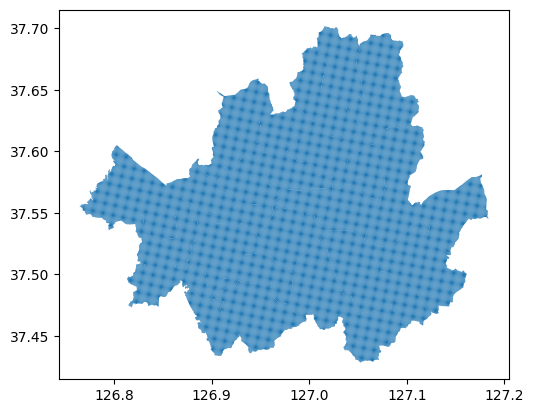

In [5]:
# 좌표계를 미터 단위로 변환 (EPSG: 32652)
seoul = seoul.to_crs(epsg=32652)

# 경계 bounds (전체 영역)
minx, miny, maxx, maxy = seoul.total_bounds

# 격자 만들기 (100m 단위로 나눔)
grid_size = 100  # 100 meters
grid_cells = []

for x0 in np.arange(minx, maxx, grid_size):
    for y0 in np.arange(miny, maxy, grid_size):
        x1 = x0 + grid_size
        y1 = y0 + grid_size
        cell = box(x0, y0, x1, y1)
        grid_cells.append(cell)

# GeoDataFrame으로 변환
grid = gpd.GeoDataFrame(geometry=grid_cells, crs="EPSG:32652")

# 영역 내 격자 필터
grid = gpd.overlay(grid, seoul, how='intersection')

# 다시 WGS84로 변환
grid = grid.to_crs(epsg=4326)

# 저장 및 시각화
grid.to_file("data/seoul_grid_100m.geojson", driver="GeoJSON")
grid.plot()

In [6]:
grid["centroid"] = grid.geometry.centroid
grid["centroid_lat"] = grid.centroid.y
grid["centroid_lon"] = grid.centroid.x
filtered_grid = grid[['geometry', 'SIG_KOR_NM','centroid_lat','centroid_lon']]

C:\Users\omslu\AppData\Local\Temp\ipykernel_26904\624547033.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid["centroid"] = grid.geometry.centroid
C:\Users\omslu\AppData\Local\Temp\ipykernel_26904\624547033.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid["centroid_lat"] = grid.centroid.y
C:\Users\omslu\AppData\Local\Temp\ipykernel_26904\624547033.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid["centroid_lon"] = grid.centroid.x


In [7]:
filtered_grid.head()

,geometry,SIG_KOR_NM,centroid_lat,centroid_lon
0,"POLYGON ((126.76561 37.5557, 126.76563 37.5549...",강서구,37.555328,126.765147
1,"POLYGON ((126.76561 37.5557, 126.76519 37.5556...",강서구,37.555768,126.765465
2,"POLYGON ((126.7666 37.55391, 126.76653 37.5538...",강서구,37.553848,126.766456
3,"POLYGON ((126.76676 37.55482, 126.76679 37.554...",강서구,37.554358,126.766540
4,"POLYGON ((126.76561 37.5557, 126.76674 37.5557...",강서구,37.555308,126.766217


## 데이터 수집 함수

In [10]:
def check_point_in_grid(lat, lon, grid_gdf):
    """
    위경도가 grid_gdf 구역 안에 있는지 확인
    포함된 구역의 index를 반환
    """
    point = Point(lon, lat)  # 경도, 위도 순서
    
    point_gdf = gpd.GeoDataFrame(geometry=[point], crs="EPSG:4326") # EPSG 4326인 좌표계에서서
    point_gdf = point_gdf.to_crs(grid_gdf.crs) # grid_gdf 좌표계로 변환

    # 해당 point를 포함하는 셀 찾기
    matched = grid_gdf[grid_gdf.geometry.contains(point_gdf.geometry[0])]    

    if not matched.empty:
        return matched.index  # 포함된 격자 인덱스 반환

def count_point_in_grid(grid_gdf, target_df, target_col):
    """
    check_point_in_grid를 통해 카운트
    """
    grid_gdf[target_col] = 0
    for index, row in target_df.iterrows():
        lat = row['lat']
        lon = row['lon']
        idx = check_point_in_grid(lat, lon, grid_gdf)
        if idx is not None:
            grid_gdf.loc[idx, target_col] += 1
    
    return grid_gdf

def get_grid_data(row, grid_gdf, col):
    """
    check_point_in_grid를 통해 grid_gdf 구역의 데이터(col) 추출
    """
    idx_list = check_point_in_grid(row['centroid_lat'], row['centroid_lon'], grid_gdf)
    if idx_list is not None:
        last_commercial = grid_gdf.loc[idx_list]
        return last_commercial[col].sum()
    return 0

def get_passenger(grid_gdf, passenger_df):
    """
    위경도가 grid_gdf 구역 안에 있는지 확인 -> 있다면 승하차수를 반환환
    """
    grid_gdf['bus_avg_board'] = 0
    grid_gdf['bus_avg_alight'] = 0

    for i, row in passenger_df.iterrows():
        lat, lon = row['lat'], row['lon']
        point = Point(lon, lat)

        point_gdf = gpd.GeoDataFrame(geometry=[point], crs="EPSG:4326")
        point_gdf = point_gdf.to_crs(grid_gdf.crs)
        matched = grid_gdf[grid_gdf.geometry.contains(point_gdf.geometry[0])]

        if not matched.empty:
            idx = matched.index[0]
            grid_gdf.at[idx, 'bus_avg_board'] += row['bus_avg_alight']
            grid_gdf.at[idx, 'bus_avg_alight'] += row['bus_avg_alight']

    return grid_gdf

def find_nearest_point(A_df, B_df):
    A_coords = np.radians(A_df[['centroid_lat', 'centroid_lon']].values)
    B_coords = np.radians(B_df[['lat', 'lon']].values)

    tree = BallTree(B_coords, metric='haversine')
    distances, indices = tree.query(A_coords, k=1)

    # Convert radians to meters (Earth radius = 6371000m)
    nearest_distances = distances.flatten() * 6371000

    return nearest_distances

## 초중고등학교 여부 데이터
- 학교 200m 이내에 100x100m 격자가 있다면 1, 없으면 0

In [11]:
school = pd.read_csv("data/전국초중등학교위치표준데이터.csv", encoding='cp949')
school.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11985 entries, 0 to 11984
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   학교ID      11985 non-null  object 
 1   학교명       11985 non-null  object 
 2   학교급구분     11985 non-null  object 
 3   설립일자      11985 non-null  object 
 4   설립형태      11985 non-null  object 
 5   본교분교구분    11985 non-null  object 
 6   운영상태      11985 non-null  object 
 7   소재지지번주소   11985 non-null  object 
 8   소재지도로명주소  11983 non-null  object 
 9   시도교육청코드   11985 non-null  int64  
 10  시도교육청명    11985 non-null  object 
 11  교육지원청코드   11985 non-null  int64  
 12  교육지원청명    11985 non-null  object 
 13  생성일자      11985 non-null  object 
 14  변경일자      11978 non-null  object 
 15  위도        11985 non-null  float64
 16  경도        11985 non-null  float64
 17  데이터기준일자   11985 non-null  object 
 18  제공기관코드    11985 non-null  object 
 19  제공기관명     11985 non-null  object 
dtypes: float64(2), int64(2), obj

In [12]:
geometry = [Point(lon, lat) for lon, lat in zip(school['경도'], school['위도'])]
school_gdf = gpd.GeoDataFrame(school, geometry=geometry, crs='EPSG:4326')

In [13]:
school_gdf = school_gdf.to_crs(epsg=3857)
# 200m 버퍼 생성
school_gdf['buffer_200m'] = school_gdf.buffer(200)
school_gdf = school_gdf.set_geometry('buffer_200m').to_crs(epsg=4326)

In [14]:
filtered_grid['isSchool'] = filtered_grid.apply(
    lambda row: 1 if check_point_in_grid(row['centroid_lat'], row['centroid_lon'], school_gdf) is not None else 0,
    axis=1
)

c:\Users\omslu\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


## 공공자전거 일평균 대여/반납 수
- 공공자전거 거치대 200m 이내에 100x100m 격자가 있다면 대여/반납수 추가

In [15]:
bycicle_df = pd.read_csv('data/서울특별시 공공자전거 대여이력 정보_2401.csv', encoding='cp949')
bycicle_df['대여일시'] = pd.to_datetime(bycicle_df['대여일시'])
bycicle_df['반납일시'] = pd.to_datetime(bycicle_df['반납일시'])
bycicle_df['대여일시'] = bycicle_df['대여일시'].dt.strftime('%Y-%m-%d')
bycicle_df['반납일시'] = bycicle_df['반납일시'].dt.strftime('%Y-%m-%d')

In [16]:
# 각 대여소의 일별 평균 대여량
outdf = bycicle_df[['대여일시', '대여대여소ID']]
outdf['대여수'] = 0
outdf = outdf.groupby(["대여일시","대여대여소ID"]).count().reset_index()
outdf = outdf[['대여대여소ID','대여수']].groupby("대여대여소ID").mean().reset_index()

# 각 대여소의 일별 평균 반납량
indf = bycicle_df[['대여일시', '반납대여소ID']]
indf['반납수'] = 0
indf = indf.groupby(["대여일시","반납대여소ID"]).count().reset_index()
indf = indf[['반납대여소ID','반납수']].groupby("반납대여소ID").mean().reset_index()

C:\Users\omslu\AppData\Local\Temp\ipykernel_26904\3518979659.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outdf['대여수'] = 0
C:\Users\omslu\AppData\Local\Temp\ipykernel_26904\3518979659.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indf['반납수'] = 0


In [17]:
outin_df= pd.merge(
    outdf,
    indf,
    left_on='대여대여소ID',            
    right_on='반납대여소ID',           
    how='left'      
)
print(outin_df.shape)
outin_df.head()

(2729, 4)


,대여대여소ID,대여수,반납대여소ID,반납수
0,ST-10,26.032258,ST-10,27.838710
1,ST-1000,35.096774,ST-1000,34.225806
2,ST-1002,62.032258,ST-1002,66.677419
3,ST-1003,17.935484,ST-1003,17.903226
4,ST-1004,14.290323,ST-1004,6.677419


In [18]:
bycicle_key_df = pd.read_csv("data/서울시 따릉이대여소 마스터 정보.csv", encoding='cp949')  # 각 대여소 ID의 위경도값
bycicle_key_df = bycicle_key_df[bycicle_key_df['위도'] != 0] # 위경도가 0인 데이터는 사라진 대여소임임
bycicle_key_df = bycicle_key_df[['대여소_ID', '위도', '경도']]
bycicle_key_df.head() 

,대여소_ID,위도,경도
2,ST-997,37.534390,126.869598
3,ST-996,37.524334,126.850548
4,ST-995,37.510597,126.857323
5,ST-994,37.529163,126.872749
6,ST-993,37.521511,126.857384


In [19]:
bycicle_merged_df= pd.merge(
    outin_df,
    bycicle_key_df,
    left_on='대여대여소ID',            
    right_on='대여소_ID',           
    how='left'      
)
bycicle_merged_df = bycicle_merged_df[['대여소_ID', '대여수', '반납수', '위도', '경도']]
print(bycicle_merged_df.shape)
bycicle_merged_df.head()

(2729, 5)


,대여소_ID,대여수,반납수,위도,경도
0,ST-10,26.032258,27.838710,37.552746,126.918617
1,ST-1000,35.096774,34.225806,37.510380,126.866798
2,ST-1002,62.032258,66.677419,37.529900,126.876541
3,ST-1003,17.935484,17.903226,37.539551,126.828300
4,ST-1004,14.290323,6.677419,37.514099,126.831001


In [20]:
geometry = [Point(lon, lat) for lon, lat in zip(bycicle_merged_df['경도'], bycicle_merged_df['위도'])]
bicycle_gdf = gpd.GeoDataFrame(bycicle_merged_df, geometry=geometry, crs='EPSG:4326') 

In [21]:
bicycle_gdf = bicycle_gdf.to_crs(epsg=3857)

# 300m 버퍼 생성
bicycle_gdf['buffer_300m'] = bicycle_gdf.buffer(200)

bicycle_gdf = bicycle_gdf.set_geometry('buffer_300m').to_crs(epsg=4326)

In [22]:
# import folium
# m = folium.Map(location=[bicycle_gdf['위도'][0], bicycle_gdf['경도'][0]], zoom_start=16)

# for idx, row in bicycle_gdf.iterrows():
#     folium.GeoJson(row['buffer_300m']).add_to(m)
# m 

In [23]:
cols = ['대여수', '반납수']
for idx, grid in filtered_grid.iterrows():
    bike_rent_count = get_grid_data(grid, bicycle_gdf, cols)
    filtered_grid.loc[idx, cols] = 	bike_rent_count

In [24]:
filtered_grid[400:405]

,geometry,SIG_KOR_NM,centroid_lat,centroid_lon,isSchool,대여수,반납수
400,"POLYGON ((126.78713 37.5552, 126.7871 37.5561,...",강서구,37.555664,126.787681,0,0.0,0.0
401,"POLYGON ((126.7871 37.5561, 126.78707 37.557, ...",강서구,37.556564,126.787654,0,0.0,0.0
402,"POLYGON ((126.78707 37.557, 126.78705 37.5579,...",강서구,37.557465,126.787627,0,0.0,0.0
403,"POLYGON ((126.78705 37.5579, 126.78702 37.5588...",강서구,37.558366,126.787601,0,0.0,0.0
404,"POLYGON ((126.78702 37.55881, 126.78699 37.559...",강서구,37.559266,126.787574,0,0.0,0.0


## 아파트
- 아파트 200m 이내에 100x100m 격자가 있다면 1*전체세대수, 없으면 0

In [25]:
apart = pd.read_csv("data/서울시 공동주택 아파트 정보.csv", encoding='cp949')
apart = apart.dropna(subset=['좌표X', '좌표Y'])
geometry = [Point(lon, lat) for lon, lat in zip(apart['좌표X'], apart['좌표Y'])]
apart_gdf = gpd.GeoDataFrame(apart, geometry=geometry, crs='EPSG:4326') 

In [26]:
apart_gdf = apart_gdf.to_crs(epsg=3857)

# 200m 버퍼 생성
apart_gdf['buffer_200m'] = apart_gdf.buffer(200)

apart_gdf = apart_gdf.set_geometry('buffer_200m').to_crs(epsg=4326)

In [27]:
# m = folium.Map(location=[apart_gdf['좌표Y'][0], apart_gdf['좌표X'][0]], zoom_start=16)

# for idx, row in apart_gdf.iterrows():
#     folium.GeoJson(row['buffer_200m']).add_to(m)
# m 

In [28]:
cols = ['k-전체세대수']
for idx, grid in filtered_grid.iterrows():
    isApart = get_grid_data(grid, apart_gdf, cols)
    filtered_grid.loc[idx, cols] = 	isApart

## 병원 데이터 수집
- 가장 가까운 병원과의 거리

In [29]:
hp = pd.read_csv("data/서울시 병의원 위치 정보.csv", encoding='cp949')
hp['lat'] = hp['병원위도']
hp['lon'] = hp['병원경도']
closest_hospital_dist = find_nearest_point(filtered_grid, hp)
filtered_grid['closest_hospital_dist'] = closest_hospital_dist

## 편의시설(카페, 편의점 등) 데이터 수집
- 가장 가까운 편의시설과의 거리

In [30]:
convenience = pd.read_csv("data/서울시 휴게음식점 인허가 정보.csv", encoding="cp949")
convenience = convenience[convenience["영업상태명"] != "폐업"]
convenience = convenience[["사업장명", "업태구분명", "좌표정보(X)", "좌표정보(Y)"]]
convenience = convenience.dropna(subset=['좌표정보(X)'])
print(convenience.업태구분명.unique())
convenience.head()

['일반조리판매' '편의점' '기타 휴게음식점' '커피숍' '아이스크림' '패스트푸드' '떡카페' '푸드트럭' '키즈카페'
 '전통찻집' '다방' '과자점' '백화점' '관광호텔' '철도역구내' '극장' '단란주점' '유원지' '호프/통닭' '공항'
 '고속도로']


C:\Users\omslu\AppData\Local\Temp\ipykernel_26904\1665010848.py:1: DtypeWarning: Columns (36,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  convenience = pd.read_csv("data/서울시 휴게음식점 인허가 정보.csv", encoding="cp949")


,사업장명,업태구분명,좌표정보(X),좌표정보(Y)
201,씨유용두대박점,일반조리판매,202797.6917,452606.9442
202,씨유제기휴플러스,편의점,203333.4117,453886.8963
203,다빼드림,기타 휴게음식점,205404.7715,451678.7415
204,세븐일레븐 휘경본점,기타 휴게음식점,204963.1275,454325.0890
205,아임유,커피숍,205230.2898,453833.2910


In [31]:
convenience = gpd.GeoDataFrame(convenience, geometry=gpd.points_from_xy(convenience['좌표정보(X)'], convenience['좌표정보(Y)']), crs="EPSG:5174")
# 좌표계 변환 (EPSG:4326으로)
convenience = convenience.to_crs("EPSG:4326")

# 위경도(lat, lon) 칼럼 생성
convenience['lat'] = convenience.geometry.y
convenience['lon'] = convenience.geometry.x

closest_convenience_dist = find_nearest_point(filtered_grid, convenience)
filtered_grid['closest_convenience_dist'] = closest_convenience_dist

## 문화시설(도서관, 극장 등) 데이터 수집
- 가장 가까운 문화시설과의 거리

In [32]:
culture = pd.read_csv("data/서울시 문화공간 정보.csv", encoding='cp949')
culture = culture[['주제분류', '위도', '경도']]
print(culture.주제분류.unique())
culture['lat'], culture['lon'] = culture['위도'], culture['경도']
closest_culture_dist = find_nearest_point(filtered_grid, culture)
filtered_grid['closest_culture_dist'] = closest_culture_dist

['기타' '공연장' '도서관' '문화예술회관' '박물관/기념관' '문화원' '미술관/갤러리']


## 행정동 단위 유동인구수
- 20대, 30대, 40대

In [ ]:
dong_df = pd.read_csv("data/LOCAL_PEOPLE_DONG_202406.csv", index_col=False)     # 행정동코드와 유동인구
dong_code = pd.read_excel("data/행정동코드_매핑정보_20241218.xlsx", header=1)       # 행정동코드와 행정동명명
dong_code = dong_code[dong_code["CT_NM"].isin(target_districts)]


dong_df['20대'] = (
    dong_df['남자20세부터24세생활인구수'] + dong_df['남자25세부터29세생활인구수'] +
    dong_df['여자20세부터24세생활인구수'] + dong_df['여자25세부터29세생활인구수']
)

dong_df['30대'] = (
    dong_df['남자30세부터34세생활인구수'] + dong_df['남자35세부터39세생활인구수'] +
    dong_df['여자30세부터34세생활인구수'] + dong_df['여자35세부터39세생활인구수']
)

dong_df['40대'] = (
    dong_df['남자40세부터44세생활인구수'] + dong_df['남자45세부터49세생활인구수'] +
    dong_df['여자40세부터44세생활인구수'] + dong_df['여자45세부터49세생활인구수']
)

dong_df = dong_df[['행정동코드', '20대', '30대', '40대']]
dong_df = dong_df.groupby("행정동코드").mean().reset_index()

dong_df = dong_df.merge(dong_code[['H_DNG_CD', 'H_SDNG_CD','H_DNG_NM']],  # 필요한 열만 사용
                        left_on='행정동코드', right_on='H_DNG_CD',
                        how='right')
dong_df.head()

,행정동코드,20대,30대,40대,H_DNG_CD,H_SDNG_CD,H_DNG_NM
0,11110530,3591.499236,5118.855354,5134.402407,11110530,1101053,사직동
1,11110540,1201.357153,1110.971272,1244.299556,11110540,1101054,삼청동
2,11110550,1765.136784,1521.331194,2036.013325,11110550,1101055,부암동
3,11110560,1839.298161,1896.741992,2631.964010,11110560,1101056,평창동
4,11110570,686.954631,734.133770,943.249456,11110570,1101057,무악동


In [ ]:
dong_gdf = gpd.read_file("data/서울_행정동_경계_2017.geojson")
dong_gdf['adm_cd'] = dong_gdf['adm_cd'].astype(int)

dong_gdf = dong_df.merge(dong_gdf,
                        left_on='H_SDNG_CD', right_on='adm_cd',
                        how='left')

dong_gdf = dong_gdf[['H_DNG_NM', '20대', '30대', '40대', 'geometry']]
dong_gdf = gpd.GeoDataFrame(dong_gdf, geometry='geometry', crs="EPSG:4326")

In [35]:
cols = ['20대','30대','40대']
for idx, grid in filtered_grid.iterrows():
    dong_pops = get_grid_data(grid, dong_gdf, cols)
    filtered_grid.loc[idx, cols] = dong_pops
    
# 유동인구가 0으로 매핑된 곳은 한강 구역과 같은 자치구의 경계이기에 제거해도 무방
filtered_grid = filtered_grid[~(filtered_grid['20대'] == 0)].reset_index(drop=True)

## 횡단보도 데이터 수집
- 격자 내 횡단보도 수
- 가까운 횡단보도의 거리

In [36]:
cross_df = pd.read_csv("data/서울시 대로변 횡단보도 위치정보.csv", encoding='cp949')
cross_df = cross_df[cross_df['노드 WKT'].notna()].copy() # 좌표만 추출 (POINT(lon lat) → lat, lon)
cross_df[['lon', 'lat']] = cross_df['노드 WKT'].str.extract(r'POINT\(([-\d.]+) ([-\d.]+)\)').astype(float)

# 격자 내 횡단보도 수 추출
count_point_in_grid(filtered_grid, cross_df, "crosswalk_count")

# 가까운 횡단보도의 거리 추출
closest_dist = find_nearest_point(filtered_grid, cross_df)
filtered_grid['closest_cross_dist'] = closest_dist
filtered_grid.head()

,geometry,SIG_KOR_NM,centroid_lat,centroid_lon,isSchool,대여수,반납수,k-전체세대수,closest_hospital_dist,closest_convenience_dist,closest_culture_dist,20대,30대,40대,crosswalk_count,closest_cross_dist
0,"POLYGON ((126.76561 37.5557, 126.76563 37.5549...",강서구,37.555328,126.765147,0,0.0,0.0,0.0,2849.926802,3040.617223,5004.546773,4622.519257,6290.562805,6698.172107,0,3099.488563
1,"POLYGON ((126.76561 37.5557, 126.76519 37.5556...",강서구,37.555768,126.765465,0,0.0,0.0,0.0,2810.458284,3002.105183,4955.296584,4622.519257,6290.562805,6698.172107,0,3060.235113
2,"POLYGON ((126.76561 37.5557, 126.76674 37.5557...",강서구,37.555308,126.766217,0,0.0,0.0,0.0,2759.632538,2949.685512,4925.459536,4622.519257,6290.562805,6698.172107,0,3009.023632
3,"MULTIPOLYGON (((126.76674 37.55572, 126.76561 ...",강서구,37.555945,126.766239,0,0.0,0.0,0.0,2739.425194,2931.145495,4886.654827,4622.519257,6290.562805,6698.172107,0,2989.213881
4,"POLYGON ((126.76676 37.55482, 126.7679 37.5548...",강서구,37.554452,126.767361,0,0.0,0.0,0.0,2690.725009,2877.561990,4891.943021,4622.519257,6290.562805,6698.172107,0,2939.061214


## 버스정류소 데이터 수집
- 격자 내 버스정류소 수
- 가까운 버스정류소의 거리

In [37]:
bus_df = pd.read_excel("data/서울시버스정류소위치정보(20250513).xlsx")
bus_df.rename(columns={'X좌표': 'lon', 'Y좌표': 'lat'}, inplace=True)

# 격자 내 버스정류소소 수 추출
count_point_in_grid(filtered_grid, bus_df, "bus_count")

# 가까운 버스정류소소 거리 추출
closest_bus_dist = find_nearest_point(filtered_grid, bus_df)
filtered_grid['closest_bus_dist'] = closest_bus_dist
filtered_grid.head()

,geometry,SIG_KOR_NM,centroid_lat,centroid_lon,isSchool,대여수,반납수,k-전체세대수,closest_hospital_dist,closest_convenience_dist,closest_culture_dist,20대,30대,40대,crosswalk_count,closest_cross_dist,bus_count,closest_bus_dist
0,"POLYGON ((126.76561 37.5557, 126.76563 37.5549...",강서구,37.555328,126.765147,0,0.0,0.0,0.0,2849.926802,3040.617223,5004.546773,4622.519257,6290.562805,6698.172107,0,3099.488563,0,3044.438675
1,"POLYGON ((126.76561 37.5557, 126.76519 37.5556...",강서구,37.555768,126.765465,0,0.0,0.0,0.0,2810.458284,3002.105183,4955.296584,4622.519257,6290.562805,6698.172107,0,3060.235113,0,3004.804163
2,"POLYGON ((126.76561 37.5557, 126.76674 37.5557...",강서구,37.555308,126.766217,0,0.0,0.0,0.0,2759.632538,2949.685512,4925.459536,4622.519257,6290.562805,6698.172107,0,3009.023632,0,2954.237195
3,"MULTIPOLYGON (((126.76674 37.55572, 126.76561 ...",강서구,37.555945,126.766239,0,0.0,0.0,0.0,2739.425194,2931.145495,4886.654827,4622.519257,6290.562805,6698.172107,0,2989.213881,0,2933.761071
4,"POLYGON ((126.76676 37.55482, 126.7679 37.5548...",강서구,37.554452,126.767361,0,0.0,0.0,0.0,2690.725009,2877.561990,4891.943021,4622.519257,6290.562805,6698.172107,0,2939.061214,0,2885.534212


## 지하철역 데이터 수집
- 격자 내 버스정류소 수
- 가까운 버스정류소의 거리

In [38]:
subway_df = pd.read_csv("data/서울시 역사마스터 정보.csv", encoding='cp949')
subway_df.rename(columns={'위도': 'lat', '경도': 'lon'}, inplace=True)

# 격자 내 지하철역 수
count_point_in_grid(filtered_grid, subway_df, "subway_count")
filtered_grid.head()

# 가까운 지하철역역 거리 추출
closest_subway_dist = find_nearest_point(filtered_grid, subway_df)
filtered_grid['closest_subway_dist'] = closest_subway_dist
filtered_grid.head()

,geometry,SIG_KOR_NM,centroid_lat,centroid_lon,isSchool,대여수,반납수,k-전체세대수,closest_hospital_dist,closest_convenience_dist,closest_culture_dist,20대,30대,40대,crosswalk_count,closest_cross_dist,bus_count,closest_bus_dist,subway_count,closest_subway_dist
0,"POLYGON ((126.76561 37.5557, 126.76563 37.5549...",강서구,37.555328,126.765147,0,0.0,0.0,0.0,2849.926802,3040.617223,5004.546773,4622.519257,6290.562805,6698.172107,0,3099.488563,0,3044.438675,0,1778.448009
1,"POLYGON ((126.76561 37.5557, 126.76519 37.5556...",강서구,37.555768,126.765465,0,0.0,0.0,0.0,2810.458284,3002.105183,4955.296584,4622.519257,6290.562805,6698.172107,0,3060.235113,0,3004.804163,0,1811.836386
2,"POLYGON ((126.76561 37.5557, 126.76674 37.5557...",강서구,37.555308,126.766217,0,0.0,0.0,0.0,2759.632538,2949.685512,4925.459536,4622.519257,6290.562805,6698.172107,0,3009.023632,0,2954.237195,0,1872.026666
3,"MULTIPOLYGON (((126.76674 37.55572, 126.76561 ...",강서구,37.555945,126.766239,0,0.0,0.0,0.0,2739.425194,2931.145495,4886.654827,4622.519257,6290.562805,6698.172107,0,2989.213881,0,2933.761071,0,1882.096418
4,"POLYGON ((126.76676 37.55482, 126.7679 37.5548...",강서구,37.554452,126.767361,0,0.0,0.0,0.0,2690.725009,2877.561990,4891.943021,4622.519257,6290.562805,6698.172107,0,2939.061214,0,2885.534212,0,1966.206762


## 버스/지하철 승하차 수 수집
- 격자 내 버스정류장 월별 승/하차수의 평균
- 격자 내 지하철역 월별 승/하차수의 평균

In [39]:
bus_passenger = pd.read_csv("data/bus_preprocessed.csv")
bus_passenger.rename(columns={'위도': 'lat', '경도': 'lon'}, inplace=True)
subway_passenger = pd.read_csv("data/subway_preprocessed.csv")
subway_passenger.rename(columns={'위도': 'lat', '경도': 'lon'}, inplace=True)

In [40]:
filtered_grid['bus_avg_board'] = 0
filtered_grid['bus_avg_alight'] = 0
filtered_grid['subway_avg_board'] = 0
filtered_grid['subway_avg_alight'] = 0
# GeoDataFrame으로 변환
bus_passenger_gdf = gpd.GeoDataFrame(bus_passenger, geometry=gpd.GeoSeries.from_xy(bus_passenger['lon'], bus_passenger['lat']), crs="EPSG:4326")
subway_passenger_gdf = gpd.GeoDataFrame(subway_passenger, geometry=gpd.GeoSeries.from_xy(subway_passenger['lon'], subway_passenger['lat']), crs="EPSG:4326")

# 좌표계를 filtered_grid와 맞추기
bus_passenger_gdf = bus_passenger_gdf.to_crs(filtered_grid.crs)
subway_passenger_gdf = subway_passenger_gdf.to_crs(filtered_grid.crs)

# Spatial Join -> 각 포인트가 포함되는 셀을 찾음
bus_joined = gpd.sjoin(bus_passenger_gdf, filtered_grid, how="inner", predicate='within')
subway_joined = gpd.sjoin(subway_passenger_gdf, filtered_grid, how="inner", predicate='within')

# 승차수와 하차수 누적 합산
filtered_grid['bus_avg_board'] = bus_joined.groupby('index_right')['avg_daily_board'].sum()
filtered_grid['bus_avg_alight'] = bus_joined.groupby('index_right')['avg_daily_alight'].sum()

filtered_grid['subway_avg_board'] = subway_joined.groupby('index_right')['avg_daily_board'].sum()
filtered_grid['subway_avg_alight'] = subway_joined.groupby('index_right')['avg_daily_alight'].sum()

filtered_grid = filtered_grid.fillna({"subway_avg_board": 0, "subway_avg_alight": 0})
filtered_grid = filtered_grid.fillna({"bus_avg_board": 0, "bus_avg_alight": 0})

## 상권/상권배후지 데이터 수집
##### 23년 데이터 (분기별 유동인구)

활용 데이터  
- 20대~40대 평균 길단위 인구수
- 20대~40대 평균 직장 인구수

인구 수

In [41]:
commercial_df = pd.read_csv("data/서울시 상권분석서비스(길단위인구-상권).csv", encoding='cp949')
wp_commercial_df = pd.read_csv("data/서울시 상권분석서비스(직장인구-상권).csv", encoding='cp949')
hinter_df = pd.read_csv("data/서울시 상권분석서비스(길단위인구-상권배후지).csv", encoding='cp949')
wp_hinter_df = pd.read_csv("data/서울시 상권분석서비스(직장인구-상권배후지).csv", encoding='cp949')

commercial_df = commercial_df[commercial_df['기준_년분기_코드'].astype(str).str.contains('2023')]
wp_commercial_df = wp_commercial_df[wp_commercial_df['기준_년분기_코드'].astype(str).str.contains('2023')]
hinter_df = hinter_df[hinter_df['기준_년분기_코드'].astype(str).str.contains('2023')]
wp_hinter_df = wp_hinter_df[wp_hinter_df['기준_년분기_코드'].astype(str).str.contains('2023')]

commercial_df = commercial_df[['상권_코드','연령대_20_유동인구_수','연령대_30_유동인구_수','연령대_40_유동인구_수']]
wp_commercial_df = wp_commercial_df[['상권_코드','연령대_20_직장_인구_수','연령대_30_직장_인구_수','연령대_40_직장_인구_수']]
hinter_df = hinter_df[['상권배후지_코드','연령대_20_유동인구_수','연령대_30_유동인구_수','연령대_40_유동인구_수']]
wp_hinter_df = wp_hinter_df[['상권배후지_코드','연령대_20_직장_인구_수','연령대_30_직장_인구_수','연령대_40_직장_인구_수']]

commercial_df = commercial_df.groupby("상권_코드").mean().reset_index()
wp_commercial_df = wp_commercial_df.groupby("상권_코드").mean().reset_index()
hinter_df = hinter_df.groupby("상권배후지_코드").mean().reset_index()
wp_hinter_df = wp_hinter_df.groupby("상권배후지_코드").mean().reset_index()

commercial_gdf = gpd.read_file("data/서울시 상권분석서비스(영역-상권)/서울시 상권분석서비스(영역-상권).shp")
hinter_gdf = gpd.read_file("data/서울시 상권분석서비스(영역-상권배후지)/서울시 상권분석서비스(영역-상권배후지).shp")

commercial_gdf['TRDAR_CD'] = commercial_gdf['TRDAR_CD'].astype(int)
hinter_gdf['ALLEY_TRDA'] = hinter_gdf['ALLEY_TRDA'].astype(int)

commercial_gdf = commercial_gdf[commercial_gdf['SIGNGU_CD_'].isin(target_districts)]
hinter_gdf = hinter_gdf[hinter_gdf['SIGNGU_CD_'].isin(target_districts)]

commercial_gdf = commercial_gdf.merge(commercial_df, left_on='TRDAR_CD', right_on='상권_코드', how='left')
commercial_gdf = commercial_gdf.merge(wp_commercial_df, left_on='TRDAR_CD', right_on='상권_코드', how='left')
hinter_gdf = hinter_gdf.merge(hinter_df, left_on='ALLEY_TRDA', right_on='상권배후지_코드', how='left')
hinter_gdf = hinter_gdf.merge(wp_hinter_df, left_on='ALLEY_TRDA', right_on='상권배후지_코드', how='left')

In [42]:
cols = ['연령대_20_유동인구_수', '연령대_30_유동인구_수', '연령대_40_유동인구_수',
        '연령대_20_직장_인구_수', '연령대_30_직장_인구_수', '연령대_40_직장_인구_수']
df_cols = ['area20', 'area30', 'area40',
           'wp_area20','wp_area30','wp_area40']

In [43]:
commercial_info = []
filtered_grid[cols] = 0

for idx, grid in filtered_grid.iterrows():
    hinter_value = get_grid_data(grid, hinter_gdf, cols)
    commercial_info.append(hinter_value)
    filtered_grid.loc[idx, cols] = hinter_value

for idx, grid in filtered_grid.iterrows():
    commercial_value = get_grid_data(grid, commercial_gdf, cols)
    commercial_info.append(commercial_value)
    filtered_grid.loc[idx, cols] = commercial_value

C:\Users\omslu\AppData\Local\Temp\ipykernel_26904\4203106815.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '602998.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  filtered_grid.loc[idx, cols] = hinter_value
C:\Users\omslu\AppData\Local\Temp\ipykernel_26904\4203106815.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '733203.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  filtered_grid.loc[idx, cols] = hinter_value
C:\Users\omslu\AppData\Local\Temp\ipykernel_26904\4203106815.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '212.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  filtered_grid.loc[idx, cols] = hinter_value
C:\Users\omslu\App

In [44]:
col_map = dict(zip(cols, df_cols))
filtered_grid.rename(columns=col_map, inplace=True)

## 상권/상권배후지 유무
- 격자의 중심이 상권/상권배후지 내 있으면 1, 아니면 0

In [45]:
commercial_gdf = gpd.read_file("data/서울시 상권분석서비스(영역-상권배후지)/서울시 상권분석서비스(영역-상권배후지).shp")
commercial_gdf = commercial_gdf[commercial_gdf['SIGNGU_CD_'].isin(target_districts)]
commercial_gdf.to_crs("EPSG:4326")

,ALLEY_TRDA,ALLEY_TR_1,XCNTS_VALU,YDNTS_VALU,SIGNGU_CD,SIGNGU_CD_,ADSTRD_CD,ADSTRD_CD_,RELM_AR,geometry
0,3110008,배화여자대학교(박노수미술관),197060.0,453385.0,11110,종로구,11110515,청운효자동,757571.0,"POLYGON ((126.9691 37.57444, 126.96895 37.5744..."
1,3110014,경복고등학교,197480.0,453988.0,11110,종로구,11110515,청운효자동,459736.0,"POLYGON ((126.97301 37.58196, 126.97296 37.581..."
2,3110011,청운초등학교,197201.0,454154.0,11110,종로구,11110515,청운효자동,331727.0,"POLYGON ((126.96946 37.58431, 126.96931 37.584..."
3,3110015,청와대사랑채,197592.0,453605.0,11110,종로구,11110515,청운효자동,439127.0,"POLYGON ((126.97381 37.57787, 126.97366 37.577..."
4,3110007,사직공원(한국사회과학도서관),196907.0,452692.0,11110,종로구,11110530,사직동,545608.0,"POLYGON ((126.96504 37.56972, 126.96489 37.569..."
...,...,...,...,...,...,...,...,...,...,...
1066,3111078,굽은다리역 4번,212791.0,449275.0,11740,강동구,11740685,길동,712019.0,"POLYGON ((127.14699 37.53885, 127.14686 37.538..."
1067,3111084,길동신동아아파트,213092.0,449184.0,11740,강동구,11740685,길동,333346.0,"POLYGON ((127.14758 37.53882, 127.14743 37.538..."
1068,3111071,천동초등학교,212287.0,448976.0,11740,강동구,11740685,길동,318442.0,"POLYGON ((127.13895 37.53727, 127.1388 37.5372..."
1069,3111068,강동성심병원,211964.0,448494.0,11740,강동구,11740685,길동,269725.0,"POLYGON ((127.13511 37.53322, 127.13497 37.533..."


In [46]:
filtered_grid['isCommercial'] = filtered_grid.apply(
    lambda row: 1 if check_point_in_grid(row['centroid_lat'], row['centroid_lon'], commercial_gdf) is not None else 0,
    axis=1
)

## 견인 데이터 수집
- 격자 내 견인 데이터 수

In [47]:
months = [1, 2, 3, 4, 5, 6]
files = [f"data/tow/서울시 전동킥보드 견인 현황_{m}월.csv" for m in months]

tow_df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
tow_df = tow_df[tow_df["구정보"].isin(target_districts)]

tow_df.head()

,번호,신고일,구정보,주소,유형,조치일,lat,lon
0,1,2024-01-01 00:00:00,송파구,서울특별시 송파구 마천동 128-127,"건물, 상가 보행자 진출입",2024-01-02 00:00:00,37.495626,127.150144
1,2,2024-01-01 00:00:00,송파구,서울특별시 송파구 거여동 604,"건물, 상가 보행자 진출입",2024-01-02 00:00:00,37.486613,127.142256
2,3,2024-01-01 00:00:00,송파구,서울특별시 송파구 장지동 839,자전거 도로,2024-01-02 00:00:00,37.482425,127.130549
3,4,2024-01-01 00:00:00,서대문구,서울특별시 서대문구 연희동 88-16,"횡단보도, 산책로 등",2024-01-04 00:00:00,37.568798,126.932277
4,5,2024-01-01 00:00:00,동작구,서울특별시 동작구 흑석동 253-4,보도 중앙,2024-01-02 00:00:00,37.500635,126.960440


In [48]:
# 견인 데이터 추출
count_point_in_grid(filtered_grid, tow_df, "tow_count")
filtered_grid.head()

,geometry,SIG_KOR_NM,centroid_lat,centroid_lon,isSchool,대여수,반납수,k-전체세대수,closest_hospital_dist,closest_convenience_dist,...,subway_avg_board,subway_avg_alight,area20,area30,area40,wp_area20,wp_area30,wp_area40,isCommercial,tow_count
0,"POLYGON ((126.76561 37.5557, 126.76563 37.5549...",강서구,37.555328,126.765147,0,0.0,0.0,0.0,2849.926802,3040.617223,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,"POLYGON ((126.76561 37.5557, 126.76519 37.5556...",강서구,37.555768,126.765465,0,0.0,0.0,0.0,2810.458284,3002.105183,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2,"POLYGON ((126.76561 37.5557, 126.76674 37.5557...",강서구,37.555308,126.766217,0,0.0,0.0,0.0,2759.632538,2949.685512,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3,"MULTIPOLYGON (((126.76674 37.55572, 126.76561 ...",강서구,37.555945,126.766239,0,0.0,0.0,0.0,2739.425194,2931.145495,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4,"POLYGON ((126.76676 37.55482, 126.7679 37.5548...",강서구,37.554452,126.767361,0,0.0,0.0,0.0,2690.725009,2877.561990,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


In [ ]:
filtered_grid.to_csv("data/seoul_grid_100m.csv", index=False)

In [103]:
# import folium

# gdf1 = filtered_grid.to_crs(epsg=4326)
# gdf2 = commercial_gdf.to_crs(epsg=4326)
# gdf3 = hinter_gdf.to_crs(epsg=4326)

# # 중심 좌표 계산
# center = gdf1.geometry.centroid.unary_union.centroid
# m = folium.Map(location=[center.y, center.x], zoom_start=12)

# # GeoJson 각각 추가 (색 지정)
# folium.GeoJson(gdf1, name='격자', style_function=lambda x: {'color': 'blue', 'fillOpacity': 1}).add_to(m)
# folium.GeoJson(gdf2, name='상권', style_function=lambda x: {'color': 'orange', 'fillOpacity': 0.5}).add_to(m)
# folium.GeoJson(gdf3, name='상권배후지', style_function=lambda x: {'color': 'green', 'fillOpacity': 0.5}).add_to(m)

# folium.LayerControl().add_to(m)

# for _, row in tow_df.iterrows():
#     lat = row['lat']
#     lon = row['lon']
    
#     # 견인횟수에 따라 마커 크기 조정
#     folium.Circle(
#         location=[lat, lon],
#         color='red',
#         fill=False,
#         fill_opacity=0.8,
#     ).add_to(m)


# folium.LayerControl().add_to(m)

# m